In [2]:
import os
import sys
dir_paths = ['dependencies']
sys.path += [os.path.join(os.getcwd(), dir_path) for dir_path in dir_paths]

import numpy as np
import torch
import torch.nn as nn 
import torch.nn.functional as F
import rlutil.torch.pytorch_util as ptu
from collections import deque
import einops
import math
import matplotlib.pyplot as plt

from gcsl.tools import dotdict
from gcsl.algo.transformer_idm import DiscreteIDMPolicy
from gcsl.algo.idm import S_DiscreteIDMPolicy
from gcsl.algo.dec_idm import DiscreteDEC_IDMPolicy
from gcsl.algo.masking import (generate_random_goal_mask, generate_k_ahead_goal_mask,
                               generate_square_subsequent_mask,
                               generate_restrictive_square_subsequent_mask)
from rlutil.logging import log_utils, logger
from gcsl import envs
from gcsl.algo import buffer, gcsl, variants, networks

%load_ext autoreload
%autoreload 2

c:\Users\msmic\Documents\code\rl\carla\rl_ad\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
env_name = 'lunar'
env = envs.create_env(env_name)
env_params = envs.get_env_params(env_name)
env_params['max_timesteps'] = 2500
print(env_params)

{'eval_freq': 2000, 'eval_episodes': 50, 'max_trajectory_length': 50, 'max_timesteps': 2500, 'goal_threshold': 0.08}


In [ ]:
model_args = dotdict(
            d_model=32,
            nhead=1,
            layers=1,
            max_len=50,    
            dropout=0.1,
            device='cpu'
        )
idm_args = dotdict(
        use_transformer = False,
        # policy_class = DiscreteIDMPolicy,
        # policy_class = DiscreteDEC_IDMPolicy,
        restrictive_masking = True,
)
env, policy, replay_buffer, gcsl_kwargs = variants.get_params(env, env_params, 
                                            idm_args=idm_args,
                                            model_args=model_args)
policy = S_DiscreteIDMPolicy(env, model_args)
gcsl_kwargs['log_tensorboard'] = True
gcsl_kwargs['eval_freq'] = 1000
algo = gcsl.GCSL(
    env,
    policy,
    replay_buffer,
    idm_args=idm_args,
    **gcsl_kwargs
)
gcsl_kwargs

In [3]:
actions = np.random.rand(20000, 50)
traj_idxss = np.random.randint(0,20000, (256))
act_ts = np.arange(50)
actions[traj_idxss].shape

(256, 50)

In [4]:
exp_prefix = '%s/gcsl' % (env_name,)
output_dir='/tmp'
with log_utils.setup_logger(exp_prefix=exp_prefix, log_base_dir=output_dir):
    # pass
    algo.train()

NameError: name 'algo' is not defined

In [7]:
buffer = np.load('tmp\\vicreg_idm_variants\lunar\gcsl_idm1l_gm_8\\2023_02_20_12_34_20\\buffer.pkl', allow_pickle=True)

In [8]:
buffer.keys()

dict_keys(['internal_goals', 'states', 'actions', 'store_actions', 'desired_states'])

In [25]:
np_goals = env.extract_goal(buffer['states'])
states = torch.tensor(buffer['states'])
th_goals = env.extract_goal(states)
np_goals.shape, th_goals.shape

((3189, 50, 5), torch.Size([3189, 50, 5]))

In [81]:
goal_full = env.sample_goal()
goal = env.extract_goal(goal_full)
goal_full, goal, states[0,10], env.extract_goal(states[0,10])

(array([-0.14372717,  0.        , -0.16093261, -0.47141062, -0.11364087,
        -0.37922401,  0.        ,  0.        ]),
 array([-0.14372717,  0.        , -0.11364087,  0.        ,  0.        ]),
 tensor([-0.0916,  1.4905, -0.4571,  0.1920,  0.1342,  0.1492,  0.0000,  0.0000]),
 tensor([-0.0916,  1.4905,  0.1342,  0.0000,  0.0000]))

In [214]:
idxs = torch.randint(0,50,(256,))
X_s = torch.rand(256,50,8)
X_s_c = X_s.clone()
X_s_c = einops.rearrange(X_s_c, 'b t h -> t b h')
X_g = torch.rand(8)

In [217]:
X, gamma, beta = torch.rand(50, 32, 8), torch.rand(1, 32, 8), torch.rand(1, 32, 8)

In [ ]:
goal = env.sample_goal()
goal

array([-0.52181495,  0.        , -0.24763215, -0.39715649, -0.0305856 ,
        0.0686049 ,  0.        ,  0.        ])

In [31]:
X = torch.rand(32,50,8)

In [35]:
slow = []
fast = env.extract_goal(X)
for i in range(X.shape[0]):
    slow.append(env.extract_goal(X[i]))
(einops.rearrange(slow, 'b t h -> b t h') == fast).all()

tensor(True)

In [24]:
th_goals[0,0],np_goals[0,0],(th_goals.numpy() == np_goals).all()

(tensor([-0.0045,  1.4150,  0.0052,  0.0000,  0.0000], dtype=torch.float16),
 array([-0.00446033,  1.4151143 ,  0.00517525,  0.        ,  0.        ],
       dtype=float32),
 False)

In [7]:
ptu.USE_GPU

False

In [ ]:
b_size, t = buffer['states'].shape[:2]
buffer['states'].shape, buffer['actions'].shape, buffer['internal_goals'].shape, buffer['desired_states'].shape

In [3]:
b_size, t = 32, 50
goal_mask, goal_idxs = generate_random_goal_mask(1, t)
goal_mask = einops.rearrange(goal_mask, '() t1 t2 -> t1 t2')
goal_mask.shape
# need to repeat per nhead, for custom batch masking
# goal_mask_repeated = einops.repeat(goal_mask, 'b t1 t2 -> (b nhead) t1 t2', nhead=8) 
# goal_mask_repeated.shape 

torch.Size([50, 50])

In [4]:
d = 64
state_pos_emb = nn.Embedding(50, d)
act_pos_emb = nn.Embedding(50, d)
global_pos_emb = nn.Embedding(50*2, d)
S, A = torch.rand(32,50,d), torch.rand(32,50,d)
state_pos = state_pos_emb(torch.arange(50))
state_pos = einops.rearrange(state_pos, 't h -> () t h')
act_pos = act_pos_emb(torch.arange(50))
act_pos = einops.rearrange(act_pos, 't h -> () t h')
global_pos = global_pos_emb(torch.arange(50*2))
global_pos = einops.rearrange(global_pos, 't h -> () t h')

In [5]:
S = S + state_pos
A = A + act_pos
seq, ps = einops.pack((S,A), 'b t * h') 
seq = einops.rearrange(seq, 'b t type h -> b (t type) h')
seq = seq + global_pos
seq.shape

torch.Size([32, 100, 64])

In [6]:
seq[0,98] == S[0,-1] + global_pos_emb.weight[-2]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

In [7]:
goal_mask, goal_idxs = generate_random_goal_mask(1, t*2, even_only=True)

In [8]:
mask = generate_square_subsequent_mask(100)
mask[:,-3:] = 0

In [10]:
einops.rearrange(np.array([0,1,2,3,4]), 't -> t')

array([0, 1, 2, 3, 4])

In [12]:
torch.arange(8).chunk(2)

(tensor([0, 1, 2, 3]), tensor([4, 5, 6, 7]))

In [21]:
X_a = einops.rearrange(np.array([1,2,3]), 't -> () t')
X_a.shape

(1, 3)

In [29]:
einops.pack((X_a, np.array([8])), 'none *')[0]

array([[1, 2, 3, 8]])

In [10]:
# # checking that scatter goal masking works as expected
# goal_mask_ = torch.clone(mask)
# for i in range(b_size):
#     for j in range(t):
#         goal_idx = goal_idxs[i,j].item()
#         goal_mask_[i,j,goal_idx] = False
# goal_mask.shape, goal_mask_.shape, (goal_mask == goal_mask_).all(), (goal_mask == mask).all()

In [42]:
args = dotdict(
    d_model=128,
    nhead=8,
    layers=2,
    max_len=50,    
    dropout=0.5,
    device='cpu',
)
# idm_policy = DiscreteDEC_IDMPolicy(env, args)
idm_policy = DiscreteIDMPolicy(env, args)
# simple masking, just use same for all in the batch
X = torch.tensor(buffer['states'])
actions = torch.tensor(buffer['actions'][-b_size:])
goal_mask, goal_idxs = generate_random_goal_mask(1, t)
goal_mask = einops.rearrange(goal_mask, '() t1 t2 -> t1 t2') 
X.shape, actions.shape, goal_mask.shape, goal_idxs.shape, sum([p.numel() for p in idm_policy.parameters()])

(torch.Size([1145, 50, 8]),
 torch.Size([1145, 50]),
 torch.Size([50, 50]),
 torch.Size([1, 50, 1]),
 1780740)

In [13]:
# simple k ahead masking
# k = 3
# goal_mask, goal_idxs = generate_k_ahead_goal_mask(t, k)
# goal_mask = generate_square_subsequent_mask(t)

In [14]:
idm_policy.load_state_dict(torch.load('tmp/lunar/2023_02_02_10_42_11/policy.pkl', map_location=torch.device('cpu')))

<All keys matched successfully>

In [15]:
idm_policy.train()
opt = torch.optim.Adam(idm_policy.parameters())
act_preds = idm_policy(X, mask=goal_mask,special_pe=False)
act_preds = einops.rearrange(act_preds, 't b n_acts -> (t b) n_acts')
acts = einops.rearrange(actions, 'b t -> (t b)')
act_preds.shape, acts.shape, actions.shape

(torch.Size([57250, 4]), torch.Size([57250]), torch.Size([1145, 50]))

In [53]:
a_preds = act_preds.argmax(dim=1)
(a_preds == acts).sum() / len(acts)

tensor(0.9391)

In [54]:
# load policy below
a_gcsl_preds = gcsl_policy(torch.tensor(buffer['states'][:,0,:]),
torch.tensor(env.extract_goal(buffer['desired_states']))).argmax(dim=1)

(array([386.,   0.,   0., 325.,   0.,   0.,   0.,   0.,   0., 434.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

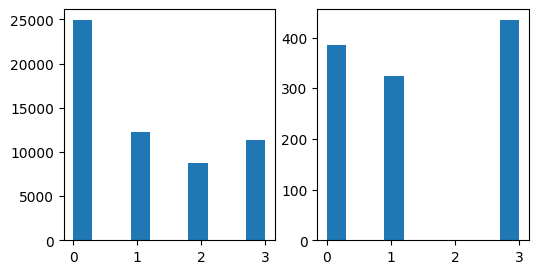

In [77]:
fig, ax = plt.subplots(figsize=(6,3) ,nrows=1, ncols=2)

ax[0].hist(a_preds.numpy())
ax[1].hist(a_gcsl_preds)

In [164]:
opt.zero_grad()
loss = idm_policy.nll(X,None,actions,mask=goal_mask)
loss.mean()
opt.step()

In [165]:
s0 = np.random.rand(1,8)
g = np.random.rand(1,8)

In [166]:
idm_policy.state_hist

deque([], maxlen=50)

In [167]:
idm_policy.reset_state_hist()
idm_policy.state_hist

deque([], maxlen=50)

In [168]:
idm_policy.eval()
for _ in range (5):
    print(idm_policy.act_vectorized(s0,g,greedy=True), len(idm_policy.state_hist))

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5


In [169]:
hist = einops.rearrange(list(idm_policy.state_hist), 't h -> t h')
hist_g, ps = einops.pack((hist, g), '* h')
hist_g = torch.tensor(hist_g, dtype=torch.float32).unsqueeze(0)
hist_g = einops.rearrange(hist_g, 'b t h -> t b h')
hist_g = idm_policy.net.state_emb(hist_g)
hist_g.shape

torch.Size([6, 1, 128])

In [170]:
pe = idm_policy.net.positional_encoder.pe
pe.shape

torch.Size([50, 1, 128])

In [171]:
targets = torch.randint(0,4, (50,3,1))
targets = einops.rearrange(targets, 't b () -> (t b)')
targets.shape

torch.Size([150])

In [172]:
logits = idm_policy(torch.rand(3,50,8), mask=goal_mask, special_pe=True)
logits = einops.rearrange(logits, 't b c_out -> (t b) c_out')
logits.shape

torch.Size([150, 4])

In [173]:
F.cross_entropy(logits, targets)

tensor(7.2365, grad_fn=<NllLossBackward0>)

In [174]:
buffer['states'].shape

(1145, 50, 8)

In [175]:
idm_policy(torch.rand(3, 50, 8), goal_mask).shape

torch.Size([50, 3, 4])

In [176]:
pack, ps = einops.pack((torch.rand(2,128),torch.rand(128)), '* h')
pack.shape, ps

(torch.Size([3, 128]), [torch.Size([2]), torch.Size([])])

In [177]:
einops.rearrange([torch.rand(10), torch.rand(10)], 't h -> t h').shape

torch.Size([2, 10])

In [178]:
obs = env.reset()
obs

array([-0.00729027,  1.4046534 , -0.7384439 , -0.27854842,  0.00845441,
        0.16726854,  0.        ,  0.        ], dtype=float32)

In [ ]:
for i in range(100):
    env.step(env.action_space.sample())
    env.render(mode='rgb_array')

In [180]:
env.action_space

Discrete(4)

In [181]:
states = np.random.rand(400,50,8)
traj_idxs = np.random.choice(400, b_size)
states.shape, traj_idxs.shape

((400, 50, 8), (1145,))

In [182]:
torch.tensor(0)

tensor(0)

In [ ]:
def generate_square_subsequent_mask(sz: int, device='cpu') -> torch.Tensor:
    return torch.triu(torch.full((sz, sz), float('-inf'), device=device), diagonal=1)

def random_goal_idxs(b_size, t):
    """Generates random goal idxs to use in masking s.t. that each goal state is sampled
       from the upper triangular matrix, so that the goal state is a future state for each
       timesteps t. 
       Except for last state as that would have no future state availble anyway -> so set to 0"""
    goal_idxs = []
    for i in range(t-1):
        goal_idxs.append(torch.randint(i+1,t, (b_size, 1, 1)))
    goal_idxs.append(torch.zeros((b_size,1,1), dtype=torch.int)) # last has no goal state anyway
    return einops.rearrange(goal_idxs, 't b () () -> b t ()')

In [ ]:
b_size, device, sz = 1, 'cpu', 50
mask = generate_square_subsequent_mask(sz, device=device).repeat(b_size,1,1)
goal_idxs = random_goal_idxs(b_size, sz).to(device)

In [ ]:
goal_mask = mask.scatter(2, goal_idxs, torch.zeros_like(goal_idxs, dtype=torch.float32, device=device))

In [ ]:
mask.shape, goal_idxs.shape

(torch.Size([1, 50, 50]), torch.Size([1, 50, 1]))

In [ ]:
# # checking that scatter goal masking works as expected
goal_mask_ = torch.clone(mask)
for i in range(b_size):
    for j in range(sz):
        goal_idx = goal_idxs[i,j].item()
        goal_mask_[i,j,goal_idx] = 0
goal_mask.shape, goal_mask_.shape, (goal_mask == goal_mask_).all(), (goal_mask == mask).all()

(torch.Size([1, 50, 50]), torch.Size([1, 50, 50]), tensor(True), tensor(False))

In [ ]:
goal_mask, goal_idxs = generate_random_goal_mask(1, t, restrictive=True)
goal_mask = einops.rearrange(goal_mask, '() t1 t2 -> t1 t2') 

In [ ]:
generate_square_subsequent_mask(3).T

tensor([[0., 0., 0.],
        [-inf, 0., 0.],
        [-inf, -inf, 0.]])

In [ ]:
encoder = nn.TransformerDecoderLayer(args.d_model, args.nhead, dropout=args.dropout)
gpt = nn.TransformerDecoder(encoder, args.layers)

In [ ]:
tgt_mask = generate_restrictive_square_subsequent_mask(t)
mem_mask, _ = generate_random_goal_mask(1, t, restrictive=True)
mem_mask = einops.rearrange(mem_mask, '() t1 t2 -> t1 t2') 
tgt_mask.shape, mem_mask.shape

(torch.Size([50, 50]), torch.Size([50, 50]))

In [ ]:
gpt(tgt=torch.rand(50,32,128),memory=torch.rand(50,32,128),
    tgt_mask=tgt_mask,memory_mask=mem_mask).shape

torch.Size([50, 32, 128])

In [ ]:
goal_mask.shape[0]

50

In [ ]:
emb = nn.Embedding(1, 128)

In [ ]:
emb(torch.zeros(30,10, dtype=torch.int)).shape

torch.Size([30, 10, 128])

In [ ]:
a,b = torch.rand(32),torch.rand(32)
x, ps = einops.pack((a,b), '* h')
sa, ga = einops.unpack(x, ps, '* h')

In [ ]:
a, b = einops.unpack(x.unsqueeze(1), ps, '* b h')

In [ ]:
sa == b

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [ ]:
a.shape, b.shape

(torch.Size([1, 32]), torch.Size([1, 32]))

# Checking policies by comparing actions towards goals

In [36]:
idm_policy # loaded above
# gcsl_policy = torch.load('tmp\lunar\gcsl\\2023_01_31_09_16_59\params.pkl',  map_location=torch.device('cpu'))
from gcsl.algo.networks import DiscreteStochasticGoalPolicy
gcsl_policy = DiscreteStochasticGoalPolicy(
                env,
                state_embedding=None,
                goal_embedding=None,
                layers=[400, 300], #[400, 300], # TD3-size
                max_horizon=None, # Do not pass in horizon.
                # max_horizon=get_horizon(env_params), # Use this line if you want to include horizon into the policy
                freeze_embeddings=True,
                add_extra_conditioning=False,
            )
gcsl_policy.load_state_dict(torch.load('tmp\lunar\gcsl\\2023_01_31_09_16_59\policy.pkl', map_location='cpu'))
idm_policy.eval()
gcsl_policy.eval()

<>:14: DeprecationWarning: invalid escape sequence \l
c:\Users\msmic\Documents\code\rl\PACT_CarRacing\gcsl\dependencies\rlutil\torch\__init__.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.fn(*args, device=device, **kwargs)


DiscreteStochasticGoalPolicy(
  (net): StateGoalNetwork(
    (state_embedding): Flatten()
    (goal_embedding): Flatten()
    (net): FCNetwork(
      (network): Sequential(
        (0): Linear(in_features=13, out_features=400, bias=True)
        (1): ReLU()
        (2): Linear(in_features=400, out_features=300, bias=True)
        (3): ReLU()
        (4): Linear(in_features=300, out_features=4, bias=True)
      )
    )
  )
)

In [70]:
dists = []
for i in range(100):
    state = env.reset()
    goal_state = env.sample_goal()
    goal = env.extract_goal(goal_state)
    idm_acts = []
    acts = []
    for i in range(50):
        idm_acts.append(idm_policy.act_vectorized(state[None], goal_state[None],greedy=True)[0])
        acts.append(gcsl_policy.act_vectorized(state[None], goal[None],greedy=True)[0])
        state, _, _, _ = env.step(acts[-1])
        # state, _, _, _ = env.step(idm_acts[-1])
    dists.append(env.goal_distance(state, goal_state))

In [71]:
np.mean(dists), np.std(dists), np.array(idm_acts), np.array(acts)

(0.06277568033131098,
 0.05698567590343996,
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], dtype=int64),
 array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 2,
        3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3], dtype=int64))

# Check that buffers work

In [183]:
from gcsl.algo.buffer import ReplayBuffer
from gcsl.algo.buffer2 import ReplayBuffer2
buffer_kwargs = dict(
        env=env,
        max_trajectory_length=50, 
        buffer_size=20000,
    )
b1 = ReplayBuffer(**buffer_kwargs)
b2 = ReplayBuffer2(**buffer_kwargs)

In [184]:
for i in range(300):
    state_traj = np.random.rand(50,8)
    act_traj = np.random.randint(0,4, (50,))
    desired_state = np.random.rand(8)    
    b1.add_trajectory(state_traj, act_traj, desired_state)
    b2.add_trajectory(state_traj, act_traj, desired_state)

In [193]:
b1_obs, b1_acts, b1_goals, _,_,_ = b1.sample_batch(32)
b2_obs, b2_acts, b2_goals, _,_,_ = b2.sample_batch(32)
b1_obs.shape, b1_acts.shape, b1_goals.shape, b2_obs.shape, b2_acts.shape#, b2_goals.shape

(32, 50, 8) (32, 50) (32,) (32,)


((32, 8), (32,), (32, 5), (32, 50, 8), (32, 50))

(32, 50, 8) (32, 50) (32,) (32,)


((32, 8), (32,), (32, 5), (32, 50, 8), (32, 50))

In [109]:
X, ps = einops.pack((b1_obs,b1_obs),'b * h')
X.shape

(32, 2, 8)

In [199]:
k = 11 
S, X_a = torch.rand(32,50,8), torch.rand(32,50,8)
X_g = S[:,k]
X_s = S[:,:k]
X_a = X_a[:,:k]
X_g.shape, X_s.shape, X_a.shape, (S[:,11]==X_g[:,:]).all()

(torch.Size([32, 8]),
 torch.Size([32, 11, 8]),
 torch.Size([32, 11, 8]),
 tensor(True))

In [202]:
seq, ps = einops.pack((X_s, X_a), 'b t * h')  
seq = einops.rearrange(seq, 'b t type h -> b (t type) h')
seq_, ps = einops.pack((X_g, seq), 'b * h')
seq_r = einops.rearrange(seq, 'b (t type) h -> b t (type h)', type=2)
seq_swapped = einops.rearrange(seq, 'b t h -> t b h')
seq_r_from_swapped = einops.rearrange(seq_swapped, '(t type) b h -> t b (type h)', type=2)
seq_r_from_swapped_flip = einops.rearrange(seq_r_from_swapped, 't b h -> b t h')
(seq_[:,1:]==seq).all(), (seq_[:,0] == X_g).all(), seq_r.shape, seq_r_from_swapped.shape, (seq_r == seq_r_from_swapped_flip).all()

(tensor(True),
 tensor(True),
 torch.Size([32, 11, 16]),
 torch.Size([11, 32, 16]),
 tensor(True))

In [204]:
(seq_r_from_swapped_flip[:,:,:8] == X_s).all(), (seq_r_from_swapped_flip[:,:,8:] == X_a).all()

(tensor(True), tensor(True))

In [92]:
list(range(10))[:5],list(range(10))[5]

([0, 1, 2, 3, 4], 5)

In [45]:
13*400+400*300+300*4

126400

In [72]:
model_args = dotdict(
            d_model=32,
            nhead=1,
            dim_f=128,
            layers=2,
            max_len=50,    
            dropout=0.1,
            device='cpu'
        )
args = model_args
s_policy = S_DiscreteIDMPolicy(env, model_args).net
sum((p.numel() for p in s_policy.parameters()))

38112

In [ ]:
s_policy.__class__

2616

In [207]:
ma = nn.MultiheadAttention(args.d_model, args.nhead)
sum((p.numel() for p in ma.parameters()))

16640

In [496]:
x, aw = ma(torch.rand(1,32,128),torch.rand(1,32,128),torch.rand(1,32,128))

In [497]:
x.shape

torch.Size([1, 32, 128])

In [455]:
13*400+400*300+300*4

126400

In [119]:
s_policy.nll(torch.rand(32,8), torch.rand(32,5), torch.randint(0,4,(32,)))

tensor([2.3657, 1.7177, 1.8693, 2.4041, 1.3371, 0.9556, 1.6673, 1.2903, 2.0574,
        1.6739, 1.2806, 1.4536, 0.8917, 1.2737, 1.0060, 1.2225, 0.5449, 0.9643,
        1.1325, 1.6127, 2.2741, 1.1900, 1.1374, 1.3841, 2.1147, 1.4831, 2.0867,
        1.5123, 1.1319, 1.9590, 1.8525, 0.9262], grad_fn=<NllLossBackward0>)

In [156]:
s_policy.act_vectorized(torch.rand(1,8), torch.rand(1,5))

array([1], dtype=int64)

In [18]:
x,_ = einops.pack((torch.rand(32,8),torch.rand(32,5)), 'b *')
x.shape

torch.Size([32, 13])

In [24]:
x = torch.rand(2,32,4)
(x[0] == einops.rearrange(x, 't b c -> (b t) c')[::2]).all()

tensor(True)

In [89]:
targets, targets_noise = torch.randint(0,4,(32,)), torch.randint(0,4,(32,))

In [94]:
r = torch.rand(32)
r

tensor([0.3469, 0.6528, 0.2868, 0.4447, 0.9027, 0.6168, 0.4720, 0.2059, 0.3292,
        0.9294, 0.0844, 0.9928, 0.7013, 0.1143, 0.7775, 0.3418, 0.2710, 0.5755,
        0.9710, 0.9418, 0.9512, 0.0286, 0.1239, 0.4795, 0.9390, 0.5312, 0.7936,
        0.8235, 0.7924, 0.8579, 0.8005, 0.2204])

In [91]:
targets

tensor([1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 1, 3, 1, 1, 2, 2, 3, 0, 2, 0, 0, 1, 0,
        0, 3, 0, 1, 3, 0, 0, 2])

In [96]:
a = torch.zeros(32)
targets[r.gt(0.5)] = targets_noise[r.gt(0.5)]

In [97]:
targets

tensor([0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 0, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 0,
        3, 1, 2, 2, 1, 0, 3, 2])

In [138]:
def noise_to_targets(targets, noise_rate=0.5, l=0,h=4, device='cpu'):
    targets = targets.clone()
    r = torch.rand(*targets.shape, device=device)
    targets_noise = torch.randint(l,h,targets.shape, device=device)
    targets[r.gt(1-noise_rate)] = targets_noise[r.gt(1-noise_rate)]
    return targets

tensor([1, 0, 3, 0, 2, 1, 1, 3, 1, 0, 3, 1, 3, 3, 2, 2, 0, 3, 1, 2, 2, 0, 0, 3,
        0, 2, 2, 2, 1, 0, 0, 2])

In [148]:
noise_to_targets(targets, noise_rate=0.4, device='cpu')

tensor([1, 0, 3, 0, 2, 1, 2, 3, 1, 0, 2, 1, 1, 3, 2, 2, 0, 2, 1, 2, 0, 0, 0, 3,
        3, 2, 0, 2, 1, 0, 1, 3])

In [5]:
def generate_traj_mask(b_size: int, sz: int, t1:np.array, t2:np.array,
                       device='cpu', mask_type='base') -> torch.Tensor:
    mask = torch.full((b_size,sz,sz),float('-inf'), device=device)
    for i in range(b_size):
        if mask_type == 'restrictive': # unmask s_k and g
            mask[i][:,t1[i]] = 0
            mask[i][:,t2[i]] = 0
        elif mask_type == 'pre': # unmask s_0,...,s_k,...,s_g
            mask[i][:,:t2[i]+1] = 0 # +1 to include s_g
        elif mask_type == 'all': # unmask everything
            mask = torch.zeros(b_size, 50, 50, device=device)
        elif mask_type == 'base': # unmask s_k,...,s_g
            mask[i][:,t1[i]:t2[i]+1] = 0 # +1 to include s_g
        else:
            raise Exception(f"mask_type = {mask_type} is an invalid mask type!")
    return mask

In [174]:
b_size=32
t1 = np.random.randint(0,49, (b_size,))
t2 = np.random.randint(0,50, (b_size,))
t2[t1 == t2] += 1
start_idx = np.minimum(t1, t2)
end_idx = np.maximum(t1, t2)
mask = generate_traj_mask(b_size,50+1,start_idx+1,end_idx+1,mask_type='base')

In [175]:
def make_state_pad_masks(b_size:int, sz:int, t1:np.array, t2:np.array, device='cpu') -> torch.Tensor: 
    src_key_padding_masks = []
    sz = 50
    for i in range(b_size):
        src_key_padding_mask = [False] * (start_idx[i]+1)
        src_key_padding_mask += [True] * (sz - (start_idx[i]+1))
        src_key_padding_mask[end_idx[i]] = 0
        src_key_padding_masks.append(src_key_padding_mask)
    src_key_padding_masks = np.asarray(src_key_padding_masks)
    return torch.tensor(src_key_padding_masks, device=device)

In [193]:
[np.zeros((8)) for i in range(4)]

[array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.])]

In [204]:
t = einops.rearrange([np.zeros(8) for i in range(4)],'t h -> t h')
t.shape

(4, 8)

In [206]:
x,ps = einops.pack((t, np.zeros(8)), '* h')
x.shape

(5, 8)

In [176]:
state_pad_masks = make_state_pad_masks(b_size, 50, start_idx, end_idx,device='cpu')
state_pad_masks[0][start_idx[0]], state_pad_masks.shape

(tensor(0, dtype=torch.int32), torch.Size([32, 50]))

In [8]:
X = torch.rand(32,50,64)
X_old = X.clone()
pe = nn.Embedding(50,64)

def add_act_tokens(X:torch.tensor, t1:np.array, t2:np.array, device:str='cpu') -> torch.tensor:
    b_size, t, h = X.size()
    new_X = torch.zeros(b_size, t+1, h, dtype=X.dtype, device=device)
    for i in range(b_size):
        new_X[i,:t1[i]+1] = X[i,:t1[i]+1]
        new_X[i, t1[i]+1:t2[i]+1] = pe.weight[t1[i]:t2[i]]
        new_X[i, t2[i]+1:] = X[i,t2[i]:]
    return new_X
X = add_act_tokens(X, start_idx, end_idx)
for k in range(b_size):
    i = 0
    s, e = start_idx[i], end_idx[i]
    print((X_old[i, :s+1] == X[i,:s+1]).all(), (pe.weight[s:e] == X[i, s+1:e+1]).all(), (X_old[i, e:] == X[i,e+1:]).all())

tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True) tensor(True)
tensor(True) tensor(True)

In [96]:
def get_act_tokens(b_size:int, sz:int, dim:int, t1:np.array, t2:np.array, device:str='cpu'):
    Z = torch.zeros(b_size, sz, dim, device=device)
    tgt_key_padding_mask = torch.zeros(b_size, sz, device=device, dtype=torch.bool)
    for i in range(b_size):
        diff = t2[i]-t1[i]
        Z[i,:diff] = pe.weight[t1[i]:t2[i]]
        tgt_key_padding_mask[i, diff:] = True
    return Z, tgt_key_padding_mask

In [97]:
Z, tgt_key_padding_mask = get_act_tokens(32, 50, 64, start_idx, end_idx)
Z[tgt_key_padding_mask]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<IndexBackward0>)

In [99]:
Z[:,:1].shape

torch.Size([32, 1, 64])

In [104]:
torch.rand(1,2,32)[torch.arange(1),np.array([1])].shape

torch.Size([1, 32])

In [33]:
t1[0], t2[0]

(20, 12)

In [24]:
X[torch.arange(32),t1].shape

torch.Size([32, 64])

In [308]:
X = torch.rand(256,50,8)
g = np.random.randint(0,50,(256,))
X_g = X[torch.arange(256), g]
X_g_ = X.take_along_dim(torch.LongTensor(g[...,None,None]), 1).squeeze(1)
X_g.shape, g.shape, (X_g_ == X_g).all(), X_g_.shape

(torch.Size([256, 8]), (256,), tensor(True), torch.Size([256, 8]))

In [62]:
start_idx[:32], end_idx[:32]

(array([12,  6, 39, 11, 11,  6, 29, 11,  7,  0, 28,  9,  1, 19, 22,  9,  1,
        23,  9,  3, 14,  3, 18, 32,  3, 15,  8, 17, 12, 11, 11,  9]),
 array([20, 46, 40, 13, 13, 38, 49, 37,  9, 11, 41, 41, 42, 37, 28, 14, 17,
        44, 34, 32, 32, 16, 20, 33,  9, 31, 44, 21, 24, 27, 13, 14]))

In [211]:
mask[0][10], mask[0][21][41]

(tensor([-inf, -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf]),
 tensor(-inf))

In [37]:
s_0, g = torch.rand(2, 1, 128)
z = torch.zeros((50+1, 1, 128), device='cpu')

torch.Size([51, 1, 128])

In [41]:
z[0] = s_0 
z[49] = g 
z[50] = torch.rand(128)

In [53]:
X_acts = torch.rand(50, 1, 4)

In [56]:
X_acts.argmax(dim=2).shape

torch.Size([50, 1])

In [58]:
X_acts.requires_grad

False

In [64]:
a = einops.repeat(torch.rand(1,32), '() h -> repeat h', repeat=256)

In [57]:
F.mse_loss(torch.rand(32),torch.rand(32))

tensor(0.1590)

In [334]:
def to(**kwargs):
    for k,v in kwargs.items():
        print(k,v)

In [335]:
to(ok=2, hi=32)

ok 2
hi 32


In [345]:
a = [torch.rand(20,4),torch.rand(13,4),torch.rand(4,4)]

In [346]:
x,_ = einops.pack(a, '* b')
x.shape

torch.Size([37, 4])

In [349]:
b = [torch.rand(20),torch.rand(13),torch.rand(4)]
einops.pack(b, '*')[0].shape

torch.Size([37])

In [398]:
def zerofy(X, time_state_idxs, goal_state_idxs, device='cpu'):
    b_size = X.shape[0]
    Z = torch.zeros_like(X, device=device)
    arange = torch.arange(b_size, device=device)
    Z[[arange, time_state_idxs]] = X[[arange, time_state_idxs]]
    Z[[arange, goal_state_idxs]] = X[[arange, goal_state_idxs]]
    return Z

In [399]:
x = torch.rand(b_size,50,128)
z = zerofy(x, start_idx, end_idx)

In [402]:
z[0][9] == x[0,11]

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False])

In [396]:
start_idx, end_idx

(array([10, 16, 36, ..., 15, 36, 20]), array([23, 39, 44, ..., 23, 44, 47]))

In [421]:
a = deque(maxlen=3)

In [428]:
a.append(np.random.rand(5))
a

deque([array([0.54167173, 0.79242663, 0.83581172, 0.38478615, 0.99685984]),
       array([0.46690283, 0.13800223, 0.35384076, 0.64194863, 0.38338471]),
       array([0.41691808, 0.19452532, 0.35572218, 0.71153525, 0.43183435])],
      maxlen=3)

In [429]:
einops.rearrange(list(a),'b h -> b h')

array([[0.54167173, 0.79242663, 0.83581172, 0.38478615, 0.99685984],
       [0.46690283, 0.13800223, 0.35384076, 0.64194863, 0.38338471],
       [0.41691808, 0.19452532, 0.35572218, 0.71153525, 0.43183435]])

In [438]:
einops.pack((torch.rand(32,8),torch.rand(32,8)),'b *')[0].shape

torch.Size([32, 16])

In [500]:
nn.Linear(8,8)(torch.rand(8))

tensor([-0.3598,  0.9786, -0.0271,  0.1492, -0.1496,  0.0220, -0.7949, -0.3468],
       grad_fn=<AddBackward0>)

In [501]:
np.random.rand()

0.3986627130687832

In [13]:
import numpy as np
gcsl_org_acts = np.load('tmp\lunar\gcsl\gcsl_org1\\2023_02_08_12_58_37\\stored_actions.npz', allow_pickle=True)['acts']
gcsl_msa_s_acts = np.load('tmp\lunar\gcsl\gcsl_msa_sbuf\\2023_02_07_21_50_54\\buffer.pkl', allow_pickle=True)['store_actions']
gcsl_msa_l_acts = np.load('tmp\lunar\gcsl\gcsl_msa_lbuf1\\2023_02_08_12_54_47\\stored_actions.npz')['acts']

In [14]:
gcsl_msa_l_acts.shape, gcsl_msa_s_acts.shape, gcsl_org_acts.shape

((3189, 50), (1787, 50), (3179, 50))

In [2]:
np.savez_compressed('stored_actions.npz', stored_actions=gcsl_org_buf['store_actions'])

In [57]:
stored_acts = np.load('stored_actions.npz')
stored_acts.files, stored_acts['stored_actions'].shape

(['stored_actions'], (412, 50))

In [3]:
plt.hist(gcsl_msa_l_acts.flatten())

NameError: name 'plt' is not defined

In [104]:
_actions = np.zeros(
            (100, 50, *env.action_space.shape),
            dtype=env.action_space.dtype
        )

_track_actions = np.zeros(
    (201_000, 50, *env.action_space.shape),
    dtype=env.action_space.dtype
)

_states = np.zeros(
    (100, 50, *env.state_space.shape),
    dtype=env.state_space.dtype
)
_desired_states = np.zeros(
    (100, *env.state_space.shape),
    dtype=env.state_space.dtype
)

In [106]:
current_buffer_size=100
track_pointer = 201_000
d = dict(states=_states[:current_buffer_size])
if True:
    d.update(dict(
        actions=_actions[:current_buffer_size],
        store_actions=_track_actions[:track_pointer],
        desired_states=_desired_states[:current_buffer_size],
    ))

In [109]:
import pickle
with open('test.pkl', 'wb') as fp:
    pickle.dump(d, fp)

In [111]:
pkl = np.load('test.pkl', allow_pickle=True)

In [114]:
pkl['store_actions'].shape

(201000, 50)